# Stability API - Basic Inference

**In this notebook we're going to go over how to set up the Stability SDK package, and how to use our API to perform a basic inference call.**

In [2]:
#@title <a name="Step 1"><font color="#FFFFFF">1. Install the Stability SDK package.</font></a>

%pip install stability-sdk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 3.5 MB/s 
     |████████████████████████████████| 2.4 MB 17.8 MB/s 
     |████████████████████████████████| 4.6 MB 54.8 MB/s 
     |████████████████████████████████| 1.1 MB 37.5 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.50.0
    Uninstalling grpcio-1.50.0:
      Successfully uninstalled grpcio-1.50.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.48.2 requires grpcio>=1.48.2, but you have grpcio 1.48.1 which is incompatible.


In [ ]:
#@title <a name="Step 2"><font color="#FFFFFF">2. Set up our environment variables and API Key.</font></a>

import getpass, os

# Our Host URL should not be prepended with "https" nor should it have a trailing slash.
os.environ['STABILITY_HOST'] = 'grpc.stability.ai:443'

# Sign up for an account at the following link to get an API Key. https://beta.dreamstudio.ai/membership
# Click on the following link once you have created an account to be taken to your API Key. Paste it below when prompted after running the cell. https://beta.dreamstudio.ai/membership?tab=apiKeys
os.environ['STABILITY_KEY'] = getpass.getpass('Enter your API Key')

In [4]:
#@title <a name="Step 3"><font color="#FFFFFF">3. Import additional dependencies and establish our connection to the API.</font></a>

import io
import os
import warnings

from IPython.display import display
from PIL import Image
from stability_sdk import client
import stability_sdk.interfaces.gooseai.generation.generation_pb2 as generation

# Set up our connection to the API.
stability_api = client.StabilityInference(
    key=os.environ['STABILITY_KEY'], # API Key reference.  
    verbose=True, # Print debug messages.
)

INFO:stability_sdk.client:Opening channel to grpc.stability.ai:443
INFO:stability_sdk.client:Channel opened to grpc.stability.ai:443


INFO:stability_sdk.client:Sending request.
INFO:stability_sdk.client:Got keepalive 231e1b12-3572-44d4-b9c2-a1fb19daf63a in 0.17s
INFO:stability_sdk.client:Got keepalive 231e1b12-3572-44d4-b9c2-a1fb19daf63a in 3.22s
INFO:stability_sdk.client:Got 231e1b12-3572-44d4-b9c2-a1fb19daf63a with ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 0.37s


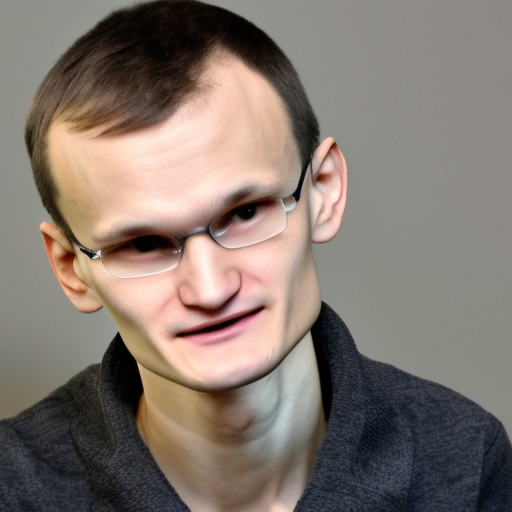

In [26]:
#@title <a name="Step 4"><font color="#FFFFFF">4. Set up initial generation parameters, display image on generation, and safety warning for if the adult content classifier is tripped.</font></a>

answers = stability_api.generate(
    prompt="Vitalik Buterin",
    seed=992446758, # If a seed is provided, the resulting generated image will be deterministic. What this means is that as long as all generation parameters remain the same, you can always recall the same image simply by generating it again. 
                    # Note: This isn't quite the case for Clip Guided generations, which we'll tackle in a future example notebook. 
    steps=50, # Step Count defaults to 50 if not specified here.
    cfg_scale=8.0, # Influences how strongly your generation is guided to match your prompt. Setting this value higher increases the strength in which it tries to match your prompt. Defaults to 7.0 if not specified.
    width=512, # Generation width, defaults to 512 if not included.
    height=512, # Generation height, defaults to 512 if not included.
    sampler=generation.SAMPLER_K_DPM_2_ANCESTRAL # Choose which sampler we want to denoise our generation with. Defaults to k_lms if not specified. Clip Guidance only supports ancestral samplers.
                                                 # (Available Samplers: ddim, plms, k_euler, k_euler_ancestral, k_heun, k_dpm_2, k_dpm_2_ancestral, k_lms)
)

# Set up our warning to print to the console if the adult content classifier is tripped. If adult content classifier is not tripped, display generated image.
for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img = Image.open(io.BytesIO(artifact.binary))
            display(img)